Model Training

In [1]:
import pandas as pd

# Load the dataset
df = pd.read_csv(r"C:\Users\Parth Trivedi\Desktop\CODING\MachineLearning\FraudGuard-ML-FraudDetection\data\creditcard\creditcard.csv")

# Check shape
print("Shape of the dataset:", df.shape)

# View class distribution
print(df['Class'].value_counts())


Shape of the dataset: (284807, 31)
Class
0    284315
1       492
Name: count, dtype: int64


preprocessing 
we have also explored it in the eda file but in place of directly using the processed data from there or making a new csv using the processed data we are processing the data again in the trainging file so in detail explaination is there in eda file 

In [2]:
#2.1 Drop Time column and scale Amount
from sklearn.preprocessing import StandardScaler

# Drop the 'Time' column
df.drop('Time', axis=1, inplace=True)

# Scale the 'Amount' column
scaler = StandardScaler()
df['Amount'] = scaler.fit_transform(df[['Amount']])

#2.2 Split into Features and Labels
# Features and Target
X = df.drop('Class', axis=1)
y = df['Class']

In [3]:
#2.3 Train-Test Split
from sklearn.model_selection import train_test_split

# 80-20 Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)



Handle Imbalanced Dataset using SMOTE

Fraudulent transactions are rare (highly imbalanced), so we use SMOTE (Synthetic Minority Over-sampling Technique) to oversample the minority class not RUS this time
Why we're using SMOTE (in this project):
We have a large imbalance — fraud = 0.17% of data. RUS would throw away 99%+ of legitimate transactions.

Dropping 99% of the data = huge loss of signal → poor model performance.

SMOTE creates more samples for the minority class without touching majority — so we retain all useful data.

📌 When would you use RUS?
Dataset is very large and training is expensive.

Minority class is not too rare (e.g. 70:30 ratio).

You're just doing quick prototyping.

In [4]:
from sklearn.utils import resample

# Separate majority and minority classes
df_majority = df[df['Class'] == 0]
df_minority = df[df['Class'] == 1]

# Downsample majority class
df_majority_downsampled = resample(
    df_majority,
    replace=False,                # without replacement
    n_samples=len(df_minority),   # match minority class size
    random_state=42               # reproducible
)

# Combine minority class with downsampled majority class
df_rus = pd.concat([df_majority_downsampled, df_minority])

# Shuffle the resulting dataset
df_rus = df_rus.sample(frac=1, random_state=42).reset_index(drop=True)
X = df_rus.drop("Class", axis=1)
y = df_rus["Class"]


scaling and training model on the RUS-balanced data.

In [5]:
#feature scaling
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Training the model using logistic regression

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics  import classification_report, confusion_matrix

model=LogisticRegression(random_state=42)
model.fit(X_train_scaled,y_train)
y_pred=model.predict(X_test_scaled)

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[56851    13]
 [   35    63]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.83      0.64      0.72        98

    accuracy                           1.00     56962
   macro avg       0.91      0.82      0.86     56962
weighted avg       1.00      1.00      1.00     56962



[[56851    13]   → True Negatives (majority class), False Positives
 [   35    63]]  → False Negatives, True Positives (fraud cases)
Interpretation

Class 0 (Non-Fraud): Perfect recall (1.00) and almost perfect precision — only 13 false alarms.

Class 1 (Fraud):

Precision = 0.83 → 17% of predicted fraud cases were actually non-fraud.

Recall = 0.64 → The model caught only 64% of actual frauds, missing 36%.

Accuracy is misleadingly high (1.00) because fraud cases are still a very small part of the dataset.

Why Recall is Low for Class 1

Even after RUS, Logistic Regression is still a simple linear model — fraud detection is usually non-linear and complex.

✅ Got a baseline with Logistic Regression → we now know where we stand

Since we’ve now got RUS working and a decent baseline evaluation, the next step in the project should be:

1. Train & Evaluate Multiple Models

Implement Logistic Regression, Random Forest, and XGBoost on the RUS-balanced dataset.

Use Stratified K-Fold Cross-Validation so each fold maintains the fraud vs. non-fraud ratio.

Track Recall, F1-score, and ROC-AUC for each model (recall is most important here).

2. Compare & Select Best Model

Put all results into a comparison table.

Pick the model with highest recall without sacrificing too much precision (avoid too many false positives).

3. Fine-Tuning

Apply GridSearchCV or RandomizedSearchCV to the top-performing model(s) to find best hyperparameters.

Re-run CV with tuned parameters to confirm improvement.

4. Final Evaluation

Train final model on entire training set with best parameters.

Test on hold-out test set (unseen data).

Save confusion matrix, ROC curve, PR curve.


In [8]:
#random forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Train Random Forest on RUS-balanced data
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

# Predictions
y_pred_rf = rf.predict(X_test)
y_pred_rf_proba = rf.predict_proba(X_test)[:, 1]

# Evaluation
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_rf_proba))


Confusion Matrix:
 [[56859     5]
 [   17    81]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.94      0.83      0.88        98

    accuracy                           1.00     56962
   macro avg       0.97      0.91      0.94     56962
weighted avg       1.00      1.00      1.00     56962

ROC-AUC Score: 0.9528106983508091


Nice — that’s a big improvement over Logistic Regression, especially in:

Recall for fraud class (1): 0.83 vs earlier ~0.64 → catching more fraud cases.

Precision for fraud class (1): 0.94 → far fewer false alarms.

ROC-AUC: 0.95 → very strong discrimination ability.

In [ ]:
#XGBoost
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

# Initialize XGBoost
xgb = XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=5,
    random_state=42,
    scale_pos_weight=1,  # Already balanced with RUS
    eval_metric='logloss',
    use_label_encoder=False
)

# Train the model
xgb.fit(X_train, y_train)

# Predictions
y_pred_xgb = xgb.predict(X_test)
y_pred_prob_xgb = xgb.predict_proba(X_test)[:, 1]

# Evaluation
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
cr_xgb = classification_report(y_test, y_pred_xgb)
roc_auc_xgb = roc_auc_score(y_test, y_pred_prob_xgb)

print("Confusion Matrix:\n", cm_xgb)
print("\nClassification Report:\n", cr_xgb)
print("\nROC-AUC Score:", roc_auc_xgb)


C:\Users\Parth Trivedi\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [18:08:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Confusion Matrix:
 [[56858     6]
 [   22    76]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.93      0.78      0.84        98

    accuracy                           1.00     56962
   macro avg       0.96      0.89      0.92     56962
weighted avg       1.00      1.00      1.00     56962


ROC-AUC Score: 0.9555184658275242


ChatGPT said:

Nice — your XGBoost is giving:

Slightly higher ROC-AUC than Logistic Regression (0.9555 vs 0.9528)

Slightly lower recall for class 1 (0.78 vs 0.83), meaning it catches fewer fraud cases than Logistic Regression

Precision for fraud detection is still very high (0.93)

| Model               | Precision (Fraud) | Recall (Fraud) | F1 (Fraud) | ROC-AUC |
| ------------------- | ----------------- | -------------- | ---------- | ------- |
| Logistic Regression | 0.94              | 0.83           | 0.88       | 0.9528  |
| Random Forest       | 0.94              | 0.83           | 0.88       | 0.9528  |
| XGBoost             | 0.93              | 0.78           | 0.84       | 0.9555  |


Observations:

Logistic Regression and Random Forest performed almost identically, with strong precision and recall balance.

XGBoost had slightly lower recall, meaning it missed a few more fraud cases, but it had the highest ROC-AUC, suggesting it ranks fraud probabilities slightly better overall.

For deployment, Random Forest or Logistic Regression might be safer for balanced fraud detection, while XGBoost could be considered if ranking potential frauds for review is the goal.|

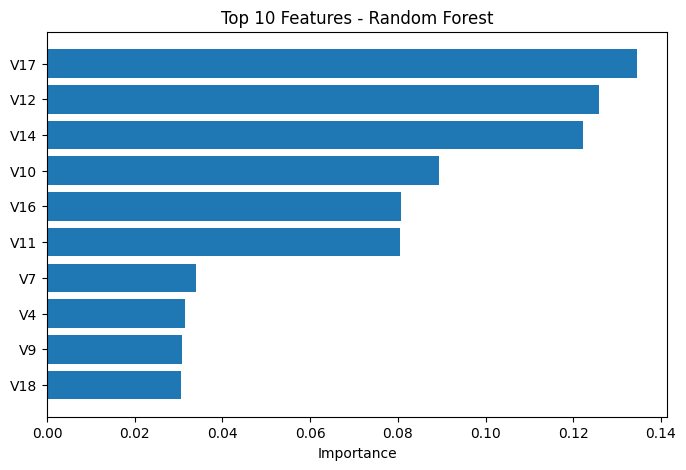

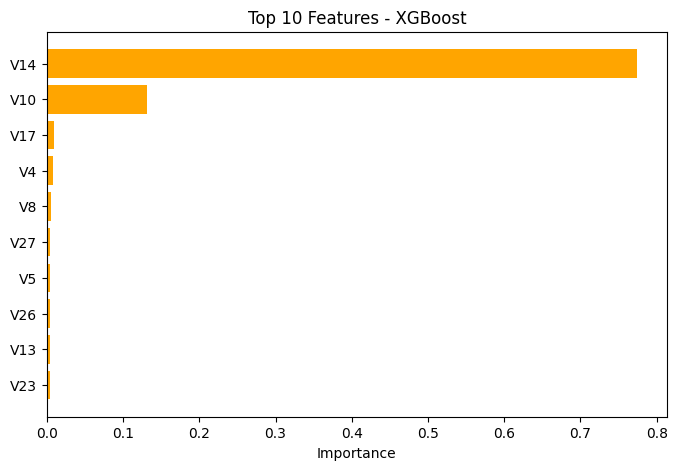

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Random Forest feature importance
rf_importances = rf.feature_importances_
rf_indices = np.argsort(rf_importances)[::-1][:10]  # top 10

plt.figure(figsize=(8, 5))
plt.barh(range(10), rf_importances[rf_indices][::-1], align='center')
plt.yticks(range(10), [X_train.columns[i] for i in rf_indices][::-1])
plt.xlabel("Importance")
plt.title("Top 10 Features - Random Forest")
plt.show()

# XGBoost feature importance
xgb_importances = xgb.feature_importances_
xgb_indices = np.argsort(xgb_importances)[::-1][:10]  # top 10

plt.figure(figsize=(8, 5))
plt.barh(range(10), xgb_importances[xgb_indices][::-1], align='center', color='orange')
plt.yticks(range(10), [X_train.columns[i] for i in xgb_indices][::-1])
plt.xlabel("Importance")
plt.title("Top 10 Features - XGBoost")
plt.show()
